# Capstone: Portfolio Optimization

In [5]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime

#Visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

#Data Optimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

#Analysis
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error


# 1. Data Wrangling

### 1.1 Upload the csv files

In [6]:
df=pd.read_csv('database2.csv')

### 1.2 Data Exploration & Preparation

In [3]:
#We can see all the columns with the close suffix that is the closing price
#and volume that is the number of transactions.
df.head(1)

date       sp5avg  timing  sp5t_close  inf_close  spr_close  \
0  2010-02-08  1103.320996       0  1056.73999    217.631       2.83   

   int_close     dj_close    dj_volume  vix_close  ...  WU_close  WYNN_close  \
0       3.62  9908.389648  216270000.0      26.51  ...     16.16   60.759998   

   WY_close  XEL_close  XOM_close  XRAY_close  XRX_close  YUM_close  \
0     39.25  20.040001  64.349998   33.099998   22.26614  23.522646   

   ZBH_close  ZION_close  
0  53.805824       17.99  

[1 rows x 406 columns]

In [4]:
#We can see that the data is clean of NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Columns: 406 entries, date to ZION_close
dtypes: float64(404), int64(1), object(1)
memory usage: 14.7+ MB


In [5]:
df.shape

(4744, 406)

# 2. Analysis of the features

### 2.1 By using linear regression model from statsmodels

In [6]:
#Lets see how the independent variables correlate to eachother
df_independent = df[['timing','sp5avg','sp5t_close','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']]

In [7]:
# Scale the data
scaler = StandardScaler()
scaler.fit(df_independent) #it is applied in all because we just want to know what's the situation of the variables
#we will not use this model for the predictions
X_independent = scaler.transform(df_independent)
column_names = ['timing','sp5avg','sp5t_close','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']
df_independent_scaled = pd.DataFrame(data=X_independent, columns=column_names)

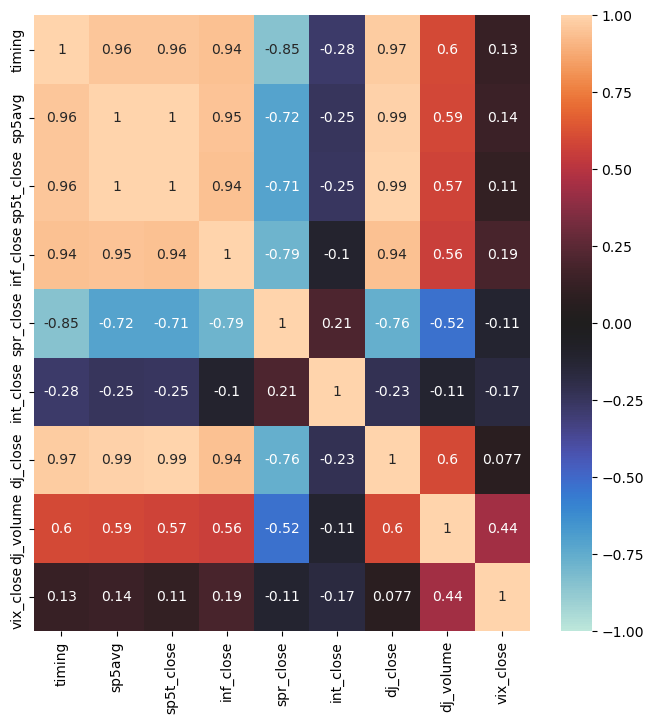

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(df_independent_scaled.corr(), annot=True, center=0, vmin=-1, vmax=1)
plt.show()

##### From the correlation table, it seems dj_close and  sp5t_close might show some multicolinearity.
##### however, that would not be a problem since we will never use them together as dependent variables.
##### Same case for dj_close and timing. But we know that they dont have any relationship.

In [9]:
# Identify independent and dependent variables as if we were trying to predict S&P500 Total
X = df_independent_scaled[['timing','sp5avg','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']]
y = df_independent_scaled['sp5t_close']

In [10]:
# Add constant
X_const = sm.add_constant(X)

# Instantiate
linearregression = sm.OLS(y, X_const)

# Fit
results = linearregression.fit()

# Check
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sp5t_close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.744e+05
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:16:00   Log-Likelihood:                 7835.2
No. Observations:                4744   AIC:                        -1.565e+04
Df Residuals:                    4735   BIC:                        -1.559e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.044e-17      0.001      6e-14      1.000      -0.001       0.001
timing        -0.0297      0.004     -6.996      0.000      -0.038      -0.021
sp5avg         0.5817      0.007     81.184      0.000       0.568       0.596
inf_close      0.0860      0.003     26.728      0.000       0.080       0.092
spr_close      0.0538      0.002     29.225      0.000       0.050       0.057
int_close     -0.0312      0.001    -33.391      0.000      -0.033      -0.029
dj_close       0.4070      0.007     59.865      0.000       0.394       0.420
dj_volume     -0.0126      0.001    -11.890      0.000      -0.015      -0.011
vix_close     -0.0104      0.001    -10.465      0.000      -0.012      -0.008
==============================================================================
Omnibus:                      338.275   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1391.991
Skew:                           0.234   Prob(JB):                    5.41e-303
Kurtosis:                       5.612   Cond. No.                         32.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### all variables seem to be significant

In [11]:
#we will drop dj_close and gold_volume
#df = df.drop(columns=['dj_close','gold_volume'])

# 3. Linear Regression

In [12]:
df.head(1)

date       sp5avg  timing  sp5t_close  inf_close  spr_close  \
0  2010-02-08  1103.320996       0  1056.73999    217.631       2.83   

   int_close     dj_close    dj_volume  vix_close  ...  WU_close  WYNN_close  \
0       3.62  9908.389648  216270000.0      26.51  ...     16.16   60.759998   

   WY_close  XEL_close  XOM_close  XRAY_close  XRX_close  YUM_close  \
0     39.25  20.040001  64.349998   33.099998   22.26614  23.522646   

   ZBH_close  ZION_close  
0  53.805824       17.99  

[1 rows x 406 columns]

In [49]:
columns = ['timing','inf_close','int_close','dj_close','dj_volume','vix_close']

In [50]:
# Train1
y_train1=df[(df['date']>'2011-02-07')&(df['date']<='2016-02-07')]
X_train1=df[df['date']<='2015-02-07']
X_t1 = X_train1[columns]
y_t1 = y_train1.iloc[:,1]
#Validation 1
y_val1=df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]
X_val1=df[(df['date']>'2015-02-07')&(df['date']<='2016-02-07')]
X_v1 = X_val1[columns]
y_v1 = y_val1.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t1)
X_t1s = scaler.transform(X_t1)
X_v1s = scaler.transform(X_v1)

# Train2
y_train2=df[(df['date']>'2011-02-07')&(df['date']<='2017-02-07')]
X_train2=df[df['date']<='2016-02-07']
X_t2 = X_train2[columns]
y_t2 = y_train2.iloc[:,1]
#Validation 2
y_val2=df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]
X_val2=df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]
X_v2 = X_val2[columns]
y_v2 = y_val2.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t2)
X_t2s = scaler.transform(X_t2)
X_v2s = scaler.transform(X_v2)

# Train3
y_train3=df[(df['date']>'2011-02-07')&(df['date']<='2018-02-07')]
X_train3=df[df['date']<='2017-02-07']
X_t3 = X_train3[columns]
y_t3 = y_train3.iloc[:,1]
#Validation 3
y_val3=df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]
X_val3=df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]
X_v3 = X_val3[columns]
y_v3 = y_val3.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t3)
X_t3s = scaler.transform(X_t3)
X_v3s = scaler.transform(X_v3)

In [51]:
# # 1. Instantiate the model
linear_regression_model1 = Lasso(alpha=10)
# # 2. Fit the model
linear_regression_model1.fit(X_t1s, y_t1)
linear_regression_model1.score(X_t1s, y_t1)

0.9366335155596052

In [52]:
linear_regression_model1.score(X_v1s,y_v1)

-0.4854903665418766

In [53]:
linear_regression_model2 = Lasso(alpha=10)
linear_regression_model2.fit(X_t2s,y_t2)
linear_regression_model2.score(X_t2s,y_t2)

0.9397721668812056

In [54]:
linear_regression_model2.score(X_v2s,y_v2)

-0.9883379537239276

In [55]:
linear_regression_model3 = Lasso(alpha=10)
linear_regression_model3.fit(X_t3s,y_t3)
linear_regression_model3.score(X_t3s,y_t3)

0.9533435952413817

In [56]:
linear_regression_model3.score(X_v3s,y_v3)

-1.6603231668430212

In [57]:
alpha = range(1, 100, 1) 

train_acc = []
val_acc = []

for n in alpha: 
    # 1. Instantiate the model
    Regression_model = Lasso(alpha=n)

    # 2. Fit the model
    Regression_model.fit(X_t1s, y_t1)
    train_acc.append(Regression_model.score(X_t1s,y_t1))
    val_acc.append(Regression_model.score(X_v1s,y_v1))

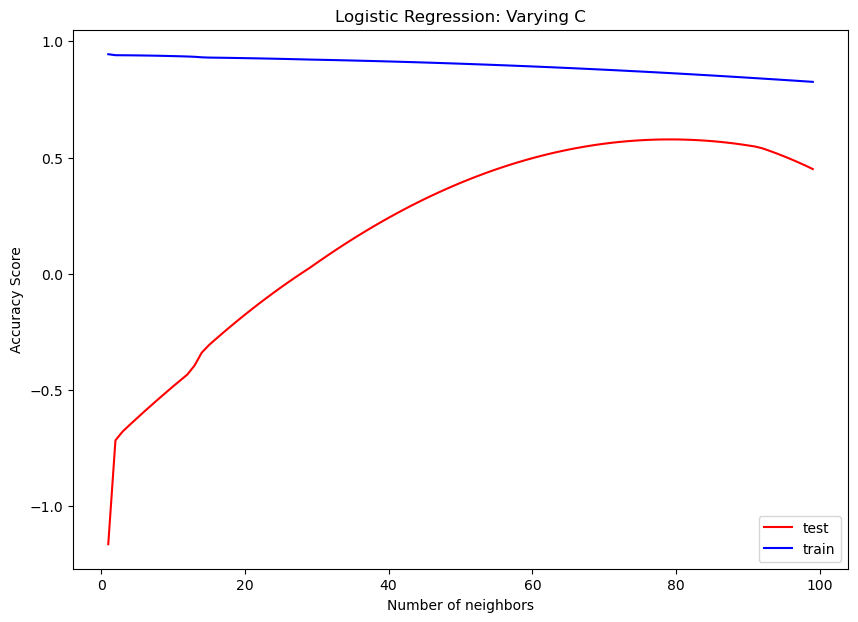

In [58]:
plt.figure(figsize=(10, 7))
plt.plot(alpha, val_acc, color="red", label="test")
plt.plot(alpha, train_acc, color="blue", label="train")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of neighbors")
plt.title('Logistic Regression: Varying C')
plt.legend()
plt.show()

In [59]:
alpha = range(1, 100, 1) 

train_acc = []
val_acc = []

for n in alpha: 
    # 1. Instantiate the model
    Regression_model = Lasso(alpha=n)

    # 2. Fit the model
    Regression_model.fit(X_t2s, y_t2)
    train_acc.append(Regression_model.score(X_t2s,y_t2))
    val_acc.append(Regression_model.score(X_v2s,y_v2))

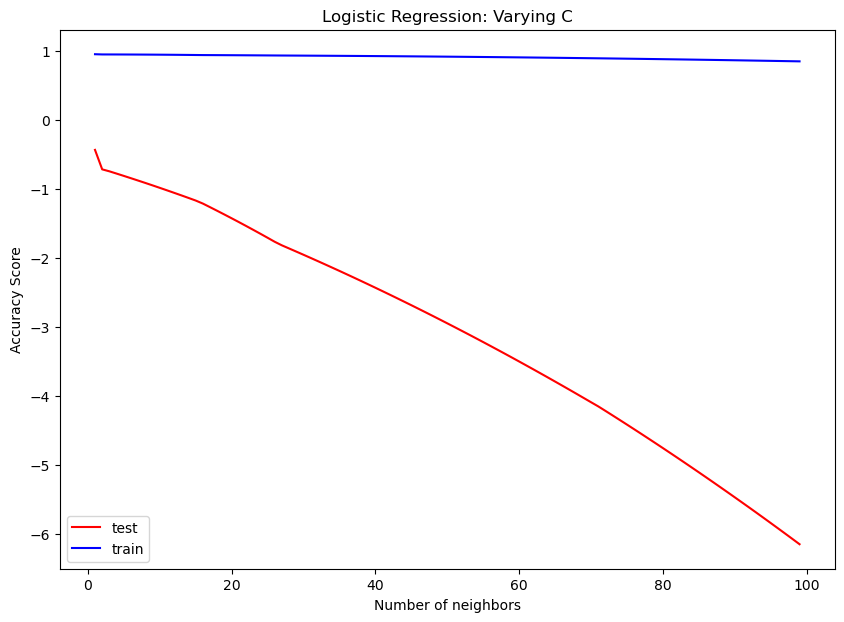

In [60]:
plt.figure(figsize=(10, 7))
plt.plot(alpha, val_acc, color="red", label="test")
plt.plot(alpha, train_acc, color="blue", label="train")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of neighbors")
plt.title('Logistic Regression: Varying C')
plt.legend()
plt.show()

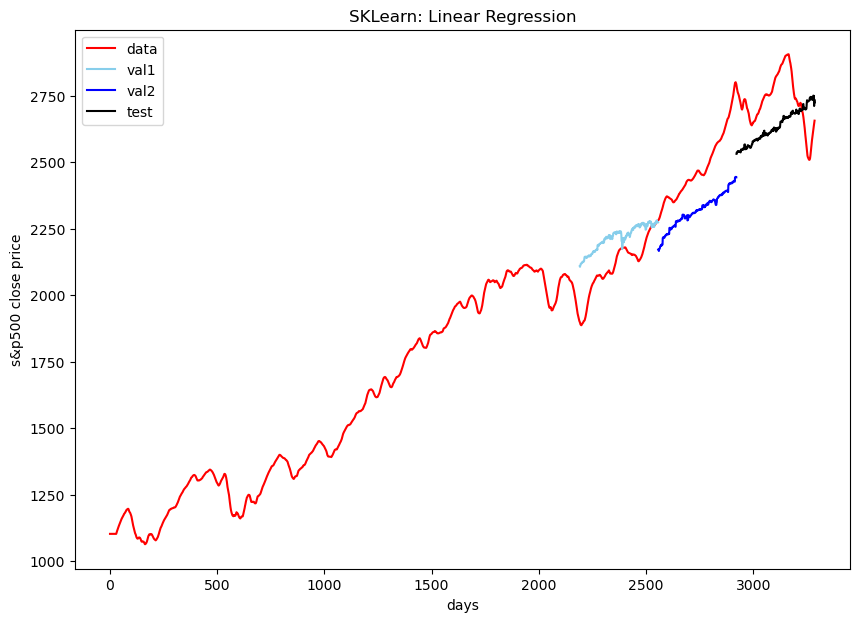

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]['timing'], df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['timing'], linear_regression_model1.predict(X_v1s), color="skyblue", label="val1")
plt.plot(df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]['timing'], linear_regression_model2.predict(X_v2s), color="blue", label="val2")
plt.plot(df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]['timing'], linear_regression_model3.predict(X_v3s), color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('SKLearn: Linear Regression')
plt.legend()
plt.show()

In [62]:
# Calculate MAE
mae1 = mean_absolute_error(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['sp5avg'], linear_regression_model1.predict(X_v1s))
mae2 = mean_absolute_error(df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]['sp5avg'], linear_regression_model1.predict(X_v2s))
mae3 = mean_absolute_error(df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]['sp5avg'], linear_regression_model1.predict(X_v3s))
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 102.5983
MAE: 261.8142
MAE: 481.1603


# 4. Sarimax

In [27]:
dfall=pd.read_csv('database(alldays)2.csv')
sarima = dfall[['date','sp5avg']].copy()
sarima = sarima.set_index('date')
sarima.index = pd.to_datetime(sarima.index)

In [28]:
sarima["sp5t_close_difference"] = sarima['sp5avg'].diff(365)

In [29]:
fig = px.line(sarima, x=sarima.index, y="sp5t_close_difference")

fig.update_layout(
    yaxis_title="Difference (billions)", 
    xaxis_title="Date",
    title="Change in Revenue Passenger Miles over Prior Year"
)

fig.show()

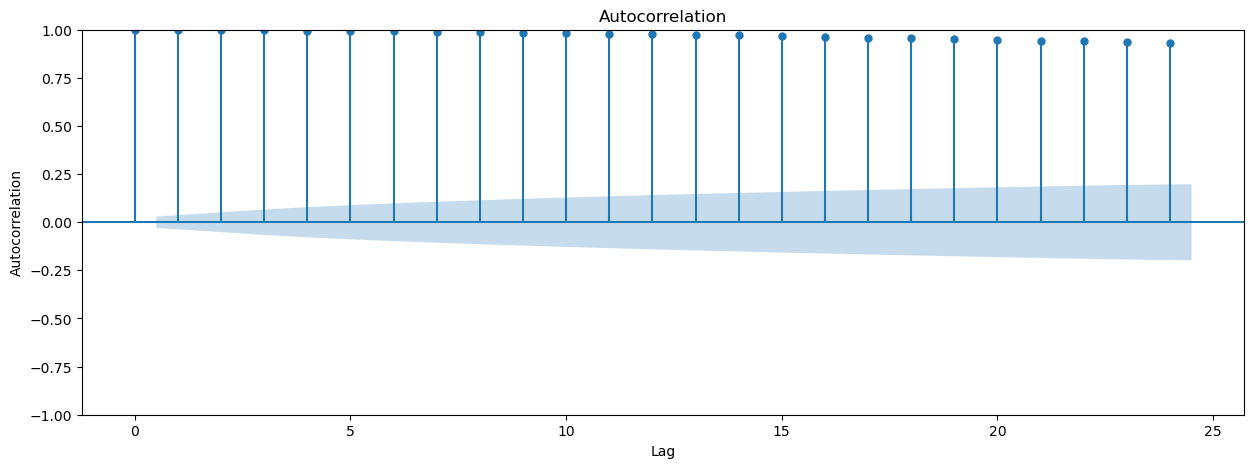

In [30]:
plt.figure(figsize=(15, 5))
plot_acf(sarima["sp5t_close_difference"].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

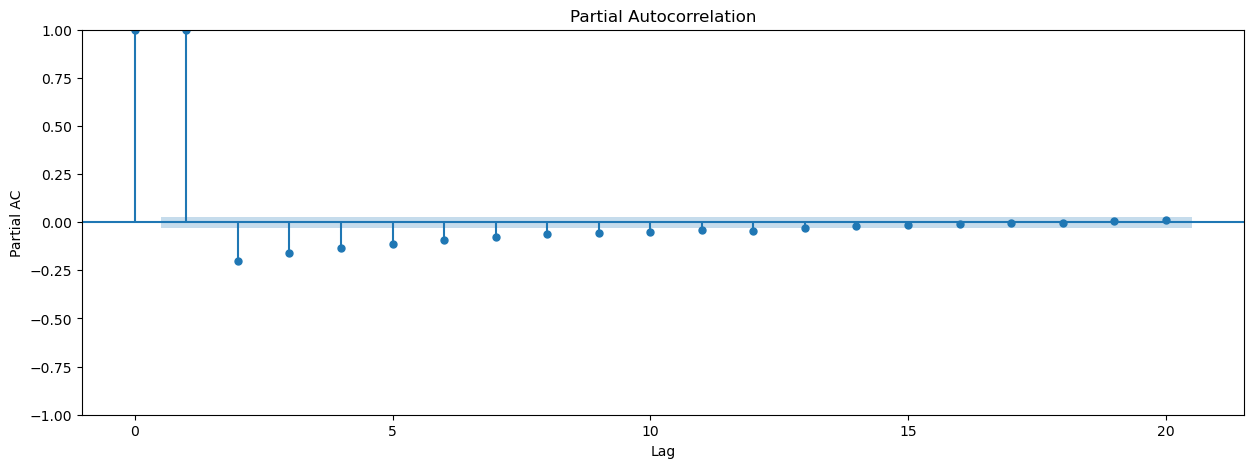

In [31]:
plt.figure(figsize=(15, 5))
plot_pacf(sarima["sp5t_close_difference"].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

In [32]:
# we drop the null values introduced at differencing

train1 = sarima[sarima.index<='2016-02-07'].dropna()
train2 = sarima[sarima.index<='2017-02-07'].dropna()
train3 = sarima[sarima.index<='2018-02-07'].dropna()
val1 = sarima[(sarima.index>'2016-02-07')&(sarima.index<='2017-02-07')]
val2 = sarima[(sarima.index>'2017-02-07')&(sarima.index<='2018-02-07')]
test = sarima[(sarima.index>'2018-02-07')&(sarima.index<='2019-02-07')]

# we only need the difference column
train1 = train1.drop(columns=['sp5avg'])
train2 = train2.drop(columns=['sp5avg'])
train3 = train3.drop(columns=['sp5avg'])
val1 = val1.drop(columns=['sp5avg'])
val2 = val2.drop(columns=['sp5avg'])
test = test.drop(columns=['sp5avg'])
train1.index = pd.to_datetime(train1.index)
train2.index = pd.to_datetime(train2.index)
train3.index = pd.to_datetime(train3.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
test.index = pd.to_datetime(test.index)

In [33]:
p_param = 13
model1 = SARIMAX(train1, order=(p_param, 0, 0), trend="c", freq="D")
model_fit1 = model1.fit(disp=0)

/Users/jorgemoya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [34]:
p_param = 13
model2 = SARIMAX(train2, order=(p_param, 0, 0), trend="c", freq="D")
model_fit2 = model2.fit(disp=0)

/Users/jorgemoya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [35]:
p_param = 13
model3 = SARIMAX(train3, order=(p_param, 0, 0), trend="c", freq="D")
model_fit3 = model3.fit(disp=0)

/Users/jorgemoya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [36]:
predictions1 = model_fit1.predict(start=0, end=len(train1)+len(val1))
predictions1 = predictions1[(predictions1.index>'2016-02-07')&(predictions1.index<='2017-02-07')]
predictions1 = predictions1.to_frame()
predictions1 = predictions1.reset_index()
predictions1.rename(columns={'index':'date','predicted_mean':'predicted1'},inplace=True)
predictions1 = predictions1.set_index('date')
predictions1.index = pd.to_datetime(predictions1.index)

In [37]:
predictions2 = model_fit2.predict(start=0, end=len(train2)+len(val2))
predictions2 = predictions2[(predictions2.index>'2017-02-07')&(predictions2.index<='2018-02-07')]
predictions2 = predictions2.to_frame()
predictions2 = predictions2.reset_index()
predictions2.rename(columns={'index':'date','predicted_mean':'predicted2'},inplace=True)
predictions2 = predictions2.set_index('date')
predictions2.index = pd.to_datetime(predictions2.index)

In [38]:
predictions3 = model_fit3.predict(start=0, end=len(train3)+len(test))
predictions3 = predictions3[(predictions3.index>'2018-02-07')&(predictions3.index<='2019-02-07')]
predictions3 = predictions3.to_frame()
predictions3 = predictions3.reset_index()
predictions3.rename(columns={'index':'date','predicted_mean':'predicted3'},inplace=True)
predictions3 = predictions3.set_index('date')
predictions3.index = pd.to_datetime(predictions3.index)

In [39]:
sarima = pd.concat([sarima,predictions1,predictions2,predictions3], axis=1)

In [40]:
sarima.index = pd.to_datetime(sarima.index)

In [42]:
sarima['restored1']=sarima['predicted1']+sarima['sp5avg'].shift(365)
sarima['restored2']=sarima['predicted2']+sarima['sp5avg'].shift(365)
sarima['restored3']=sarima['predicted3']+sarima['sp5avg'].shift(365)

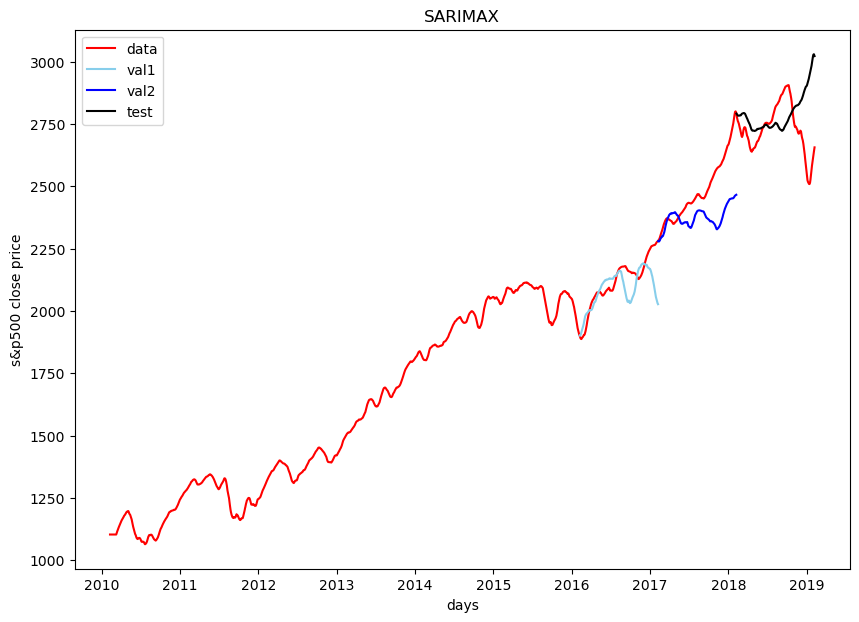

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(sarima[(sarima.index>'2010-02-07')&(sarima.index<='2019-02-07')].index, sarima[(sarima.index>'2010-02-07')&(sarima.index<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(sarima[(sarima.index>'2016-02-07')&(sarima.index<='2017-02-07')].index, sarima[(sarima.index>'2016-02-07')&(sarima.index<='2017-02-07')]['restored1'], color="skyblue", label="val1")
plt.plot(sarima[(sarima.index>'2017-02-07')&(sarima.index<='2018-02-07')].index, sarima[(sarima.index>'2017-02-07')&(sarima.index<='2018-02-07')]['restored2'], color="blue", label="val2")
plt.plot(sarima[(sarima.index>'2018-02-07')&(sarima.index<='2019-02-07')].index, sarima[(sarima.index>'2018-02-07')&(sarima.index<='2019-02-07')]['restored3'], color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('SARIMAX')
plt.legend()
plt.show()

In [45]:
# Calculate MAE
mae1 = mean_absolute_error(sarima[(sarima.index>'2016-02-07')&(sarima.index<='2017-02-07')]['sp5avg'], sarima[(sarima.index>'2016-02-07')&(sarima.index<='2017-02-07')]['predicted1'])
mae2 = mean_absolute_error(sarima[(sarima.index>'2017-02-07')&(sarima.index<='2018-02-07')]['sp5avg'], sarima[(sarima.index>'2017-02-07')&(sarima.index<='2018-02-07')]['predicted2'])
mae3 = mean_absolute_error(sarima[(sarima.index>'2018-02-07')&(sarima.index<='2019-02-07')]['sp5avg'], sarima[(sarima.index>'2018-02-07')&(sarima.index<='2019-02-07')]['predicted3'])
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 2079.3367
MAE: 2222.5393
MAE: 2422.5875


# 5. Prophet

In [19]:
prophet = df[['date','sp5avg']].copy()
prophet.rename(columns={'date':'ds','sp5avg':'y'},inplace=True)
prophet['ds']=pd.to_datetime(prophet['ds'])
train1 = prophet[prophet['ds']<='2016-02-07']
train2 = prophet[prophet['ds']<='2017-02-07']
test = prophet[prophet['ds']<='2018-02-07']

In [20]:
m = Prophet(interval_width=0.95)
training_run=m.fit(train1)
future = m.make_future_dataframe(periods=365,freq='d')
forecast1=m.predict(future)
forecast1.rename(columns={'yhat':'prediction1'},inplace=True)
forecast1 = forecast1.drop(forecast1.columns.difference(['prediction1']), axis=1)

20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:53 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
m = Prophet(interval_width=0.95)
training_run=m.fit(train2)
future = m.make_future_dataframe(periods=366,freq='d')
forecast2=m.predict(future)
forecast2.rename(columns={'yhat':'prediction2'},inplace=True)
forecast2 = forecast2.drop(forecast2.columns.difference(['prediction2']), axis=1)

20:13:54 - cmdstanpy - INFO - Chain [1] start processing
20:13:56 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
m = Prophet(interval_width=0.95)
training_run=m.fit(test)
future = m.make_future_dataframe(periods=365,freq='d')
forecast3=m.predict(future)
forecast3.rename(columns={'yhat':'prediction3'},inplace=True)
forecast3 = forecast3.drop(forecast3.columns.difference(['prediction3']), axis=1)

20:13:56 - cmdstanpy - INFO - Chain [1] start processing
20:13:58 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
prophet = pd.concat([prophet,forecast1,forecast2,forecast3], axis=1)
prophet

ds            y  prediction1  prediction2  prediction3
0    2010-02-08  1103.320996  1082.225227  1112.339821  1117.347390
1    2010-02-09  1103.320996  1084.276563  1111.042295  1116.021372
2    2010-02-10  1103.320996  1086.424639  1109.827616  1114.954378
3    2010-02-11  1103.320996  1088.627594  1109.153590  1113.780054
4    2010-02-12  1103.320996  1090.851603  1108.515267  1112.980170
...         ...          ...          ...          ...          ...
4739 2023-02-02  3985.391040          NaN          NaN          NaN
4740 2023-02-03  3994.841374          NaN          NaN          NaN
4741 2023-02-04  4005.787370          NaN          NaN          NaN
4742 2023-02-05  4013.834033          NaN          NaN          NaN
4743 2023-02-06  4021.034033          NaN          NaN          NaN

[4744 rows x 5 columns]

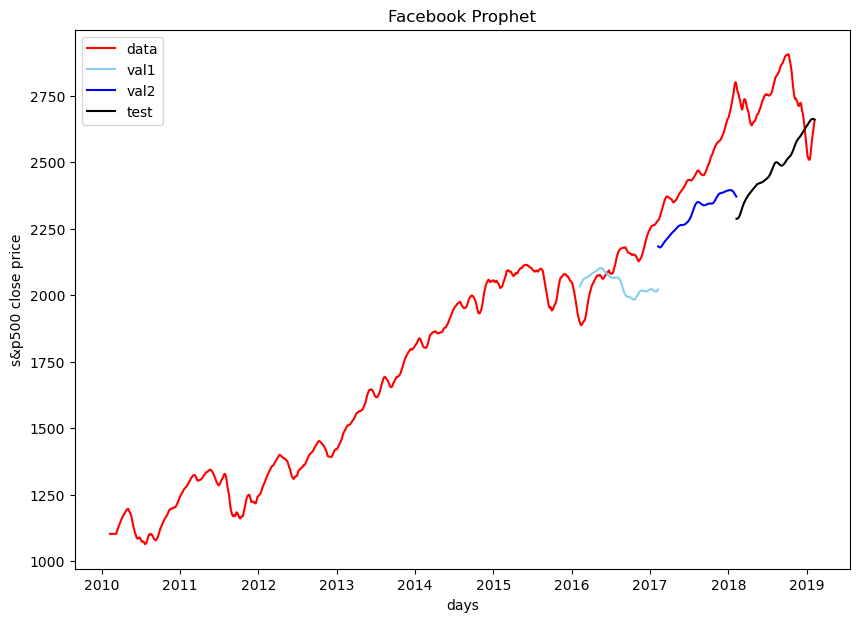

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(prophet[(prophet['ds']>'2010-02-07')&(prophet['ds']<='2019-02-07')]['ds'], prophet[(prophet['ds']>'2010-02-07')&(prophet['ds']<='2019-02-07')]['y'], color="red", label="data")
plt.plot(prophet[(prophet['ds']>'2016-02-07')&(prophet['ds']<='2017-02-07')]['ds'], prophet[(prophet['ds']>'2016-02-07')&(prophet['ds']<='2017-02-07')]['prediction1'], color="skyblue", label="val1")
plt.plot(prophet[(prophet['ds']>'2017-02-07')&(prophet['ds']<='2018-02-07')]['ds'], prophet[(prophet['ds']>'2017-02-07')&(prophet['ds']<='2018-02-07')]['prediction2'], color="blue", label="val2")
plt.plot(prophet[(prophet['ds']>'2018-02-07')&(prophet['ds']<='2019-02-07')]['ds'], prophet[(prophet['ds']>'2017-02-07')&(prophet['ds']<='2018-02-07')]['prediction3'], color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('Facebook Prophet')
plt.legend()
plt.show()

In [25]:
# Calculate MAE
mae1 = mean_absolute_error(prophet[(prophet['ds']>'2016-02-07')&(prophet['ds']<='2017-02-07')]['y'], prophet[(prophet['ds']>'2016-02-07')&(prophet['ds']<='2017-02-07')]['prediction1'])
mae2 = mean_absolute_error(prophet[(prophet['ds']>'2017-02-07')&(prophet['ds']<='2018-02-07')]['y'], prophet[(prophet['ds']>'2017-02-07')&(prophet['ds']<='2018-02-07')]['prediction2'])
mae3 = mean_absolute_error(prophet[(prophet['ds']>'2018-02-07')&(prophet['ds']<='2019-02-07')]['y'], prophet[(prophet['ds']>'2018-02-07')&(prophet['ds']<='2019-02-07')]['prediction3'])
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 118.5926
MAE: 171.3745
MAE: 137.6205


# 6. Vector Autoregressive Models

In [51]:
columns = ['timing','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']
vam = df[['date','sp5avg','timing','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']].copy()
vam['date']=pd.to_datetime(vam['date'])
vam=vam.set_index('date')
train1 = vam[(vam.index>'2010-02-07')&(vam.index<='2016-02-07')]
train2 = vam[(vam.index>'2010-02-07')&(vam.index<='2017-02-07')]
train3 = vam[(vam.index>'2010-02-07')&(vam.index<='2018-02-07')]
val1 = vam[(vam.index>'2016-02-07')&(vam.index<='2017-02-07')]
val2 = vam[(vam.index>'2017-02-07')&(vam.index<='2018-02-07')]
test = vam[(vam.index>'2018-02-07')&(vam.index<='2019-02-07')]

In [52]:
# initializing and fitting the model
model1 = VAR(train1) 
results = model1.fit(maxlags=1)
pred = results.forecast(train1.values, steps=len(val1))
forecast1 = pd.DataFrame(pred, index=val1.index, columns=train1.columns)
forecast1.rename(columns={'sp5avg':'prediction1'},inplace=True)

/Users/jorgemoya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
# initializing and fitting the model
model2 = VAR(train2) 
results = model2.fit(maxlags=1)
pred = results.forecast(train2.values, steps=len(val2))
forecast2 = pd.DataFrame(pred, index=val2.index, columns=train2.columns)
forecast2.rename(columns={'sp5avg':'prediction2'},inplace=True)

/Users/jorgemoya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [54]:
# initializing and fitting the model
model3 = VAR(train3) 
results = model3.fit(maxlags=1)
pred = results.forecast(train3.values, steps=len(test))
forecast3 = pd.DataFrame(pred, index=test.index, columns=train3.columns)
forecast3.rename(columns={'sp5avg':'prediction3'},inplace=True)

/Users/jorgemoya/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [55]:
vam = vam['sp5avg']
vam = pd.concat([vam,forecast1['prediction1'],forecast2['prediction2'],forecast3['prediction3']], axis=1)

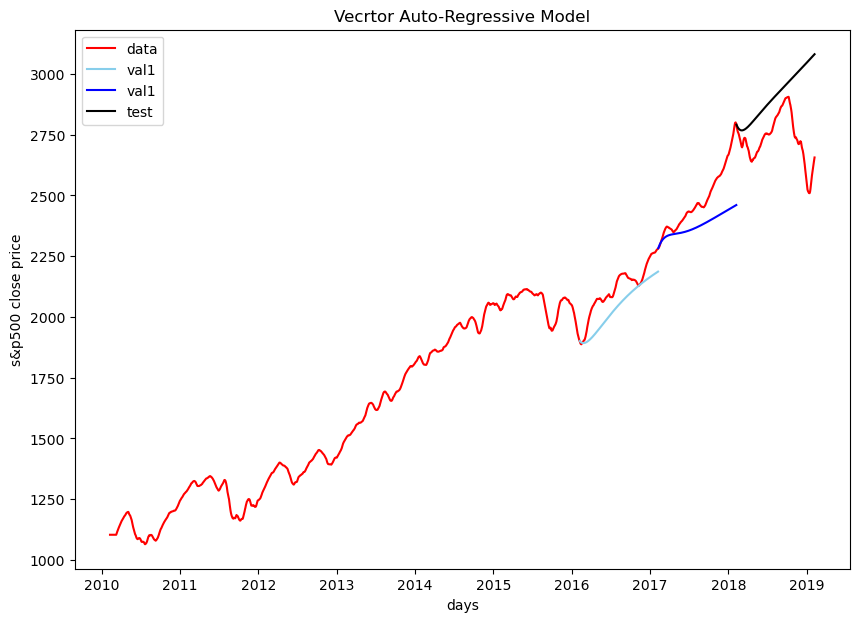

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(vam[(vam.index>'2010-02-07')&(vam.index<='2019-02-07')].index, vam[(vam.index>'2010-02-07')&(vam.index<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(vam[(vam.index>'2016-02-07')&(vam.index<='2017-02-07')].index, vam[(vam.index>'2016-02-07')&(vam.index<='2017-02-07')]['prediction1'], color="skyblue", label="val1")
plt.plot(vam[(vam.index>'2017-02-07')&(vam.index<='2018-02-07')].index, vam[(vam.index>'2017-02-07')&(vam.index<='2018-02-07')]['prediction2'], color="blue", label="val1")
plt.plot(vam[(vam.index>'2018-02-07')&(vam.index<='2019-02-07')].index, vam[(vam.index>'2018-02-07')&(vam.index<='2019-02-07')]['prediction3'], color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('Vecrtor Auto-Regressive Model')
plt.legend()
plt.show()

In [57]:
# Calculate MAE
mae1 = mean_absolute_error(vam[(vam.index>'2016-02-07')&(vam.index<='2017-02-07')]['sp5avg'], vam[(vam.index>'2016-02-07')&(vam.index<='2017-02-07')]['prediction1'])
mae2 = mean_absolute_error(vam[(vam.index>'2017-02-07')&(vam.index<='2018-02-07')]['sp5avg'], vam[(vam.index>'2017-02-07')&(vam.index<='2018-02-07')]['prediction2'])
mae3 = mean_absolute_error(vam[(vam.index>'2018-02-07')&(vam.index<='2019-02-07')]['sp5avg'], vam[(vam.index>'2018-02-07')&(vam.index<='2019-02-07')]['prediction3'])
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 74.7011
MAE: 103.1958
MAE: 178.1705


# 7. Neuronal networks

In [49]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

#Visualization
import matplotlib.pyplot as plt

In [50]:
df=pd.read_csv('database2.csv')

In [51]:
columns = ['timing','inf_close','int_close','dj_close','dj_volume','vix_close']

In [52]:
# Train1
y_train1=df[(df['date']>'2011-02-07')&(df['date']<='2016-02-07')]
X_train1=df[df['date']<='2015-02-07']
X_t1 = X_train1[columns]
y_t1 = y_train1.iloc[:,1]
#Validation 1
y_val1=df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]
X_val1=df[(df['date']>'2015-02-07')&(df['date']<='2016-02-07')]
X_v1 = X_val1[columns]
y_v1 = y_val1.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t1)
X_t1s = scaler.transform(X_t1)
X_v1s = scaler.transform(X_v1)

# Train2
y_train2=df[(df['date']>'2011-02-07')&(df['date']<='2017-02-07')]
X_train2=df[df['date']<='2016-02-07']
X_t2 = X_train2[columns]
y_t2 = y_train2.iloc[:,1]
#Validation 2
y_val2=df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]
X_val2=df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]
X_v2 = X_val2[columns]
y_v2 = y_val2.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t2)
X_t2s = scaler.transform(X_t2)
X_v2s = scaler.transform(X_v2)

# Train2
y_train3=df[(df['date']>'2011-02-07')&(df['date']<='2018-02-07')]
X_train3=df[df['date']<='2017-02-07']
X_t3 = X_train3[columns]
y_t3 = y_train3.iloc[:,1]
#Validation 3
y_val3=df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]
X_val3=df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]
X_v3 = X_val3[columns]
y_v3 = y_val3.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t3)
X_t3s = scaler.transform(X_t3)
X_v3s = scaler.transform(X_v3)

In [53]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 


model.add(layers.Dense(40, activation="relu")) 
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

history = model.fit(X_t1s, y_t1, epochs=400, verbose=0, validation_data=(X_v1s, y_v1))

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_v1s, y_v1
                        , verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred = model.predict(X_v2s)

Train Loss: 4786.4048
Test Loss: 26622.3535


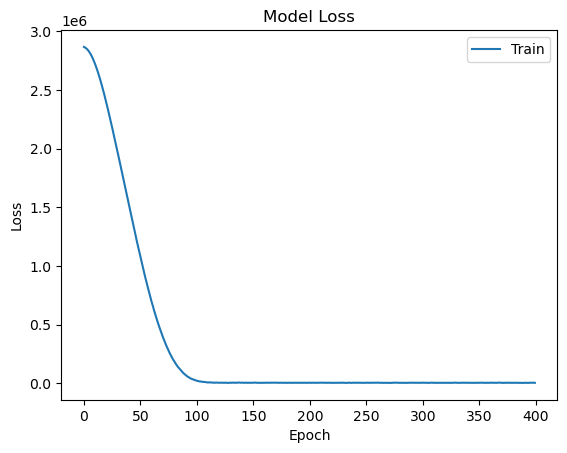

In [54]:
plt.plot(history.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'])
plt.show()

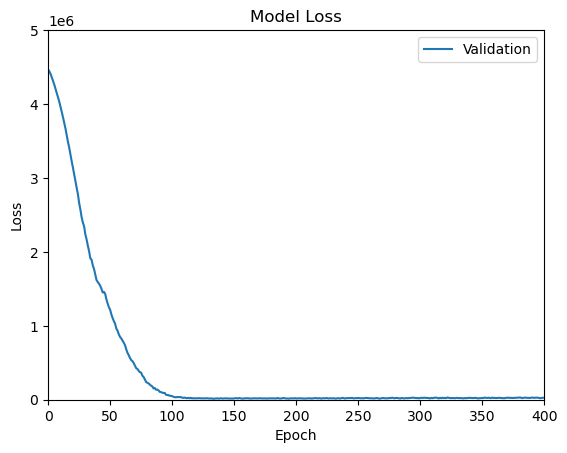

In [55]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 400)
plt.ylim(0, 5000000)
plt.legend(['Validation'])
plt.show()

In [56]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 


model.add(layers.Dense(40, activation="relu")) 
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

history = model.fit(X_t1s, y_t1, epochs=100, verbose=0, validation_data=(X_v1s, y_v1))

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_v1s, y_v1, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred1 = model.predict(X_v1s)

Train Loss: 4928.4609
Test Loss: 15183.4053


In [57]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

model.add(layers.Dense(40, activation="relu")) 
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

history = model.fit(X_t2s, y_t2, epochs=100, verbose=0, validation_data=(X_v2s, y_v2))

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_v2s, y_v2, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred2 = model.predict(X_v2s)

Train Loss: 6304.5474
Test Loss: 41288.0938


In [58]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

model.add(layers.Dense(40, activation="relu")) 
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization()) 

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

history = model.fit(X_t3s, y_t3, epochs=100, verbose=0, validation_data=(X_v3s, y_v3))

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_v3s, y_v3, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred3 = model.predict(X_v3s)

Train Loss: 10284.7236
Test Loss: 192616.2344


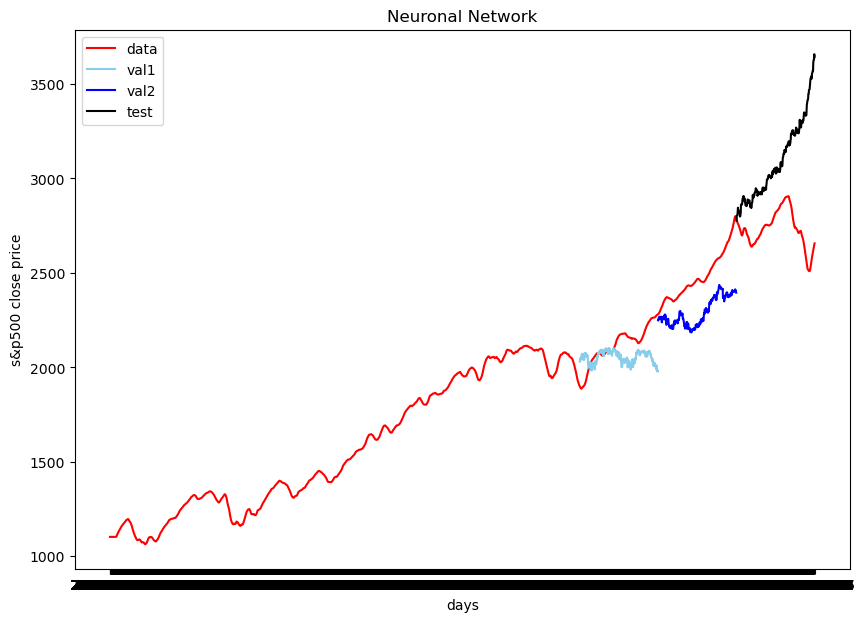

In [59]:
plt.figure(figsize=(10, 7))
plt.plot(df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]['date'], df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['date'], y_pred1 , color="skyblue", label="val1")
plt.plot(df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]['date'], y_pred2 , color="blue", label="val2")
plt.plot(df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]['date'], y_pred3 , color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('Neuronal Network')
plt.legend()
plt.show()

In [60]:
# Calculate the Mean Absolute Error on the validation set
mae1 = mean_absolute_error(y_v1, y_pred1)
mae2 = mean_absolute_error(y_v2, y_pred2)
mae3 = mean_absolute_error(y_v3, y_pred3)
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 97.1634
MAE: 187.5598
MAE: 357.7446


# 8. RNN - LSTM

In [49]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

#Visualization
import matplotlib.pyplot as plt

In [17]:
df=pd.read_csv('database2.csv')

In [18]:
columns = ['inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']

In [33]:
# Train1
y_train1=df[(df['date']>'2010-02-07')&(df['date']<='2016-02-07')]
X_train1=df[df['date']<='2015-02-07']
X_t1 = X_train1[columns]
y_t1 = y_train1.iloc[:,1]
#Validation 1
y_val1=df[(df['date']>'2016-02-01')&(df['date']<='2017-02-07')]
X_val1=df[(df['date']>'2015-02-01')&(df['date']<='2016-02-07')]
X_v1 = X_val1[columns]
y_v1 = y_val1.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t1)
X_t1s = scaler.transform(X_t1)
X_v1s = scaler.transform(X_v1)

In [34]:
# Train2
y_train2=df[(df['date']>'2011-02-07')&(df['date']<='2017-02-07')]
X_train2=df[df['date']<='2016-02-07']
X_t2 = X_train2[columns]
y_t2 = y_train2.iloc[:,1]
#Validation 2
y_val2=df[(df['date']>'2017-02-01')&(df['date']<='2018-02-07')]
X_val2=df[(df['date']>'2016-02-01')&(df['date']<='2017-02-07')]
X_v2 = X_val2[columns]
y_v2 = y_val2.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t2)
X_t2s = scaler.transform(X_t2)
X_v2s = scaler.transform(X_v2)

In [35]:
# Train3
y_train3=df[(df['date']>'2011-02-07')&(df['date']<='2018-02-07')]
X_train3=df[df['date']<='2017-02-07']
X_t3 = X_train3[columns]
y_t3 = y_train3.iloc[:,1]
#Validation 3
y_val3=df[(df['date']>'2018-02-01')&(df['date']<='2019-02-07')]
X_val3=df[(df['date']>'2017-02-01')&(df['date']<='2018-02-07')]
X_v3 = X_val3[columns]
y_v3 = y_val3.iloc[:,1]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_t3)
X_t3s = scaler.transform(X_t3)
X_v3s = scaler.transform(X_v3)

In [36]:
 # Determine the number of time steps in each sequence
time_steps = 7
# Determine the number of features (columns) in your input data
num_features = X_t1s.shape[1]

In [37]:
# Reshape the data to create sequences
def reshape_data(x, y, time_steps):
    num_samples, num_features = x.shape
    X = []
    Y = []
    for i in range(num_samples - time_steps + 1):
        X.append(x[i : i + time_steps])
        Y.append(y[i + time_steps - 1])
    return np.array(X), np.array(Y)

X_train, y_train_reshaped = reshape_data(X_t1s, y_t1.values, time_steps)
X_val, y_val_reshaped = reshape_data(X_v1s, y_v1.values, time_steps)

In [38]:
# Create a new sequential model
model = keras.Sequential()

# Declare the LSTM layer
model.add(layers.LSTM(40, activation="relu", return_sequences=True , input_shape=(time_steps, num_features)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

#Declare the LSTM layer
model.add(layers.LSTM(40, activation="relu", return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(1))  # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train_reshaped, epochs=100, batch_size=32, validation_data=(X_val, y_val_reshaped) )

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_val, y_val_reshaped, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred1 = model.predict(X_val)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 7, 40)             7520      
                                                                 
 dropout_12 (Dropout)        (None, 7, 40)             0         
                                                                 
 batch_normalization_12 (Bat  (None, 7, 40)            160       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 40)                12960     
                                                                 
 dropout_13 (Dropout)        (None, 40)                0         
                                                                 
 batch_normalization_13 (Bat  (None, 40)               160       
 chNormalization)                                     

57/57 [==============================] - 0s 7ms/step - loss: 481592.0000 - val_loss: 517762.6250
Epoch 62/100
57/57 [==============================] - 0s 7ms/step - loss: 454832.2500 - val_loss: 480682.3438
Epoch 63/100
57/57 [==============================] - 0s 8ms/step - loss: 429872.7500 - val_loss: 488217.1562
Epoch 64/100
57/57 [==============================] - 0s 7ms/step - loss: 403315.3125 - val_loss: 480859.6250
Epoch 65/100
57/57 [==============================] - 0s 7ms/step - loss: 379931.6562 - val_loss: 384499.1250
Epoch 66/100
57/57 [==============================] - 0s 7ms/step - loss: 356758.1875 - val_loss: 326787.5938
Epoch 67/100
57/57 [==============================] - 0s 8ms/step - loss: 334680.5000 - val_loss: 384329.8750
Epoch 68/100
57/57 [==============================] - 0s 7ms/step - loss: 313321.1875 - val_loss: 501237.1250
Epoch 69/100
57/57 [==============================] - 0s 7ms/step - loss: 292896.4062 - val_loss: 364044.4688
Epoch 70/100
57/57 [===

In [39]:
X_train, y_train_reshaped = reshape_data(X_t2s, y_t2.values, time_steps)
X_val, y_val_reshaped = reshape_data(X_v2s, y_v2.values, time_steps)

In [40]:
# Create a new sequential model
model = keras.Sequential()

# Declare the LSTM layer
model.add(layers.LSTM(40, activation="relu", return_sequences=True , input_shape=(time_steps, num_features)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

#Declare the LSTM layer
model.add(layers.LSTM(40, activation="relu", return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(1))  # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train_reshaped, epochs=100, batch_size=32, validation_data=(X_val, y_val_reshaped) )

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_val, y_val_reshaped, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred2 = model.predict(X_val)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 7, 40)             7520      
                                                                 
 dropout_14 (Dropout)        (None, 7, 40)             0         
                                                                 
 batch_normalization_14 (Bat  (None, 7, 40)            160       
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, 40)                12960     
                                                                 
 dropout_15 (Dropout)        (None, 40)                0         
                                                                 
 batch_normalization_15 (Bat  (None, 40)               160       
 chNormalization)                                     

69/69 [==============================] - 0s 6ms/step - loss: 436815.3438 - val_loss: 368053.7500
Epoch 62/100
69/69 [==============================] - 0s 6ms/step - loss: 404321.7812 - val_loss: 370103.3125
Epoch 63/100
69/69 [==============================] - 0s 6ms/step - loss: 374562.5625 - val_loss: 417842.2500
Epoch 64/100
69/69 [==============================] - 0s 6ms/step - loss: 345354.1250 - val_loss: 291097.8125
Epoch 65/100
69/69 [==============================] - 0s 6ms/step - loss: 318098.5625 - val_loss: 302262.1250
Epoch 66/100
69/69 [==============================] - 0s 6ms/step - loss: 290942.2500 - val_loss: 296927.3750
Epoch 67/100
69/69 [==============================] - 0s 6ms/step - loss: 266363.1562 - val_loss: 342730.5312
Epoch 68/100
69/69 [==============================] - 0s 7ms/step - loss: 243050.2969 - val_loss: 291375.4375
Epoch 69/100
69/69 [==============================] - 0s 6ms/step - loss: 221452.2656 - val_loss: 268629.5312
Epoch 70/100
69/69 [===

In [41]:
X_train, y_train_reshaped = reshape_data(X_t3s, y_t3.values, time_steps)
X_val, y_val_reshaped = reshape_data(X_v3s, y_v3.values, time_steps)

In [42]:
# Create a new sequential model
model = keras.Sequential()

# Declare the LSTM layer
model.add(layers.LSTM(40, activation="relu", return_sequences=True , input_shape=(time_steps, num_features)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

#Declare the LSTM layer
model.add(layers.LSTM(40, activation="relu", return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

# Declare the output layer
model.add(layers.Dense(1))  # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train_reshaped, epochs=100, batch_size=32, validation_data=(X_val, y_val_reshaped) )

# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_val, y_val_reshaped, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred3 = model.predict(X_val)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 7, 40)             7520      
                                                                 
 dropout_16 (Dropout)        (None, 7, 40)             0         
                                                                 
 batch_normalization_16 (Bat  (None, 7, 40)            160       
 chNormalization)                                                
                                                                 
 lstm_17 (LSTM)              (None, 40)                12960     
                                                                 
 dropout_17 (Dropout)        (None, 40)                0         
                                                                 
 batch_normalization_17 (Bat  (None, 40)               160       
 chNormalization)                                     

80/80 [==============================] - 1s 12ms/step - loss: 270561.7500 - val_loss: 477406.5938
Epoch 62/100
80/80 [==============================] - 1s 13ms/step - loss: 244391.3125 - val_loss: 226444.6406
Epoch 63/100
80/80 [==============================] - 1s 7ms/step - loss: 217537.9844 - val_loss: 243811.5000
Epoch 64/100
80/80 [==============================] - 1s 7ms/step - loss: 194145.3750 - val_loss: 290307.2188
Epoch 65/100
80/80 [==============================] - 1s 7ms/step - loss: 174013.3906 - val_loss: 356823.4375
Epoch 66/100
80/80 [==============================] - 1s 9ms/step - loss: 153616.1250 - val_loss: 342589.4375
Epoch 67/100
80/80 [==============================] - 1s 9ms/step - loss: 136106.7500 - val_loss: 356443.7188
Epoch 68/100
80/80 [==============================] - 1s 8ms/step - loss: 119591.8438 - val_loss: 213255.4688
Epoch 69/100
80/80 [==============================] - 1s 8ms/step - loss: 104975.2188 - val_loss: 212854.8438
Epoch 70/100
80/80 [=

In [43]:
len(y_pred1)

365

In [44]:
len(y_pred2)

365

In [45]:
len(y_pred3)

365

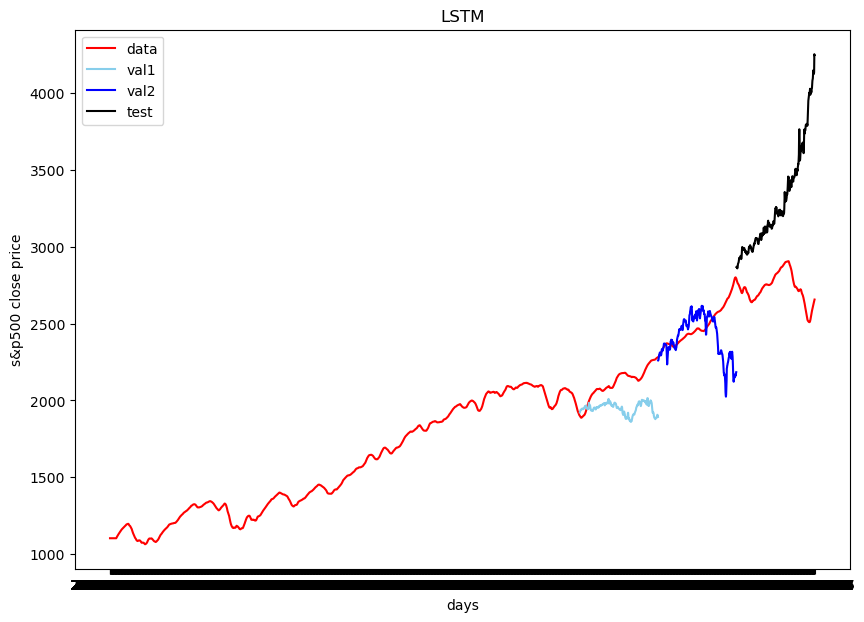

In [51]:
plt.figure(figsize=(10, 7))
plt.plot(df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]['date'], df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['date'], y_pred1 , color="skyblue", label="val1")
plt.plot(df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]['date'], y_pred2 , color="blue", label="val2")
plt.plot(df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]['date'], y_pred3 , color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('LSTM')
plt.legend()
plt.show()

In [50]:
# Calculate the Mean Absolute Error on the validation set
mae1 = mean_absolute_error(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['sp5avg'], y_pred1)
mae2 = mean_absolute_error(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['sp5avg'], y_pred2)
mae3 = mean_absolute_error(df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]['sp5avg'], y_pred3)
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 173.6456
MAE: 313.8568
MAE: 1177.8612


# 8. Merlion: Machine Learning for Time Series

In [22]:
from merlion.utils import TimeSeries
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster
from merlion.evaluate.forecast import ForecastEvaluator, ForecastEvaluatorConfig
#Base
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [6]:
df=pd.read_csv('database(alldays)2.csv')
df=df[['date','sp5avg']]
df['date']=pd.to_datetime(df['date'])

In [7]:
# Train vs Validation
X_train1=df[(df['date']>'2010-02-07')&(df['date']<='2016-02-07')]
X_val1=df[(df['date']>'2016-02-07')&(df['date']<='2017-02-07')]

# Train vs Test
X_train2=df[(df['date']>'2010-02-07')&(df['date']<='2017-02-07')]
X_val2=df[(df['date']>'2017-02-07')&(df['date']<='2018-02-07')]

# Train vs Test
X_train3=df[(df['date']>'2010-02-07')&(df['date']<='2018-02-07')]
X_test=df[(df['date']>'2018-02-07')&(df['date']<='2019-02-07')]

X_val1.set_index('date',inplace=True)
X_train1.set_index('date',inplace=True)
X_val2.set_index('date',inplace=True)
X_train2.set_index('date',inplace=True)
X_test.set_index('date',inplace=True)
X_train3.set_index('date',inplace=True)

In [8]:
# Convert pandas DataFrame to TimeSeries
train_data1 = TimeSeries.from_pd(X_train1)
test_data1 = TimeSeries.from_pd(X_val1)
# Convert pandas DataFrame to TimeSeries
train_data2 = TimeSeries.from_pd(X_train2)
test_data2 = TimeSeries.from_pd(X_val2)
# Convert pandas DataFrame to TimeSeries
train_data3 = TimeSeries.from_pd(X_train3)
test_data3 = TimeSeries.from_pd(X_test)

In [9]:
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.factory import ModelFactory

# Time series is sampled hourly, so max_forecast_steps = 24 means we can predict up to 1 day in the future
target_seq_index = 1
max_forecast_steps = 366
kwargs = dict(target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps)
model1 = ModelFactory.create("DefaultForecaster", **kwargs)
#model1 = ModelFactory.create("Arima", **kwargs)
train_pred= model1.train(train_data1)
forecast1= model1.forecast(test_data1.index)

Inferred granularity <Day>


In [10]:
train_pred2= model1.train(train_data2)
forecast2= model1.forecast(test_data2.index)

Inferred granularity <Day>


In [11]:
train_pred3= model1.train(train_data3)
forecast3= model1.forecast(test_data3.index)

Inferred granularity <Day>


In [12]:
forecast1_df, forecast1_err_df = forecast1
forecast2_df, forecast2_err_df = forecast2
forecast3_df, forecast3_err_df = forecast3

In [13]:
prediction1 = pd.DataFrame(list(forecast1_df),columns=['date', 'prediction1'])
prediction1['prediction1'] = prediction1['prediction1'].apply(lambda x: x[0])
prediction1['date'] = pd.to_datetime(prediction1['date'], unit='s')
prediction1=prediction1.set_index('date')
prediction2 = pd.DataFrame(list(forecast2_df),columns=['date', 'prediction2'])
prediction2['prediction2'] = prediction2['prediction2'].apply(lambda x: x[0])
prediction2['date'] = pd.to_datetime(prediction2['date'], unit='s')
prediction2=prediction2.set_index('date')
prediction3 = pd.DataFrame(list(forecast3_df),columns=['date', 'prediction3'])
prediction3['prediction3'] = prediction3['prediction3'].apply(lambda x: x[0])
prediction3['date'] = pd.to_datetime(prediction3['date'], unit='s')
prediction3=prediction3.set_index('date')

In [14]:
df = df.set_index('date')
df = pd.concat([df, prediction1,prediction2,prediction3], axis=1)

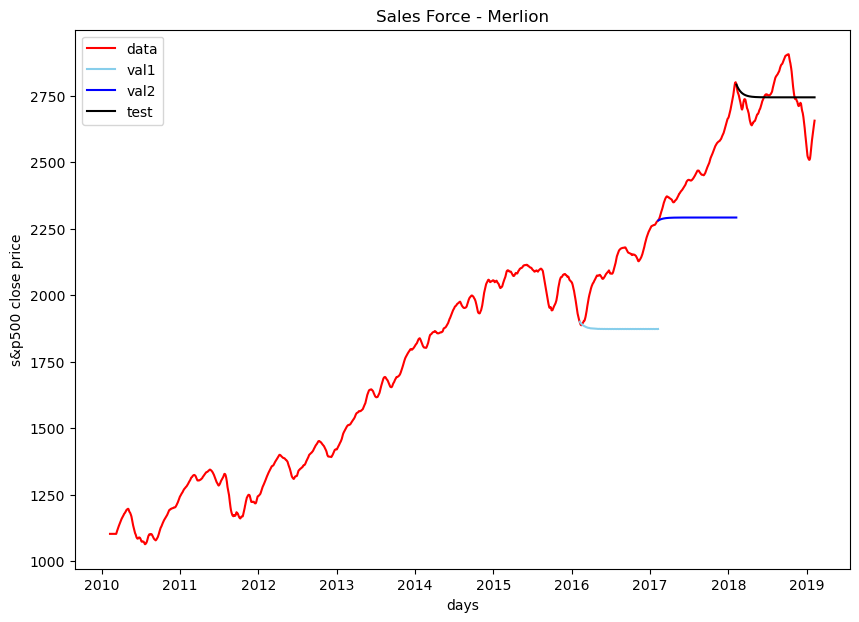

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(df[(df.index>'2010-02-07')&(df.index<='2019-02-07')].index, df[(df.index>'2010-02-07')&(df.index<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(df[(df.index>'2016-02-07')&(df.index<='2017-02-07')].index, df[(df.index>'2016-02-07')&(df.index<='2017-02-07')]['prediction1'] , color="skyblue", label="val1")
plt.plot(df[(df.index>'2017-02-07')&(df.index<='2018-02-07')].index, df[(df.index>'2017-02-07')&(df.index<='2018-02-07')]['prediction2'] , color="blue", label="val2")
plt.plot(df[(df.index>'2018-02-07')&(df.index<='2019-02-07')].index, df[(df.index>'2018-02-07')&(df.index<='2019-02-07')]['prediction3'] , color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('Sales Force - Merlion')
plt.legend()
plt.show()

In [30]:
evaluator = ForecastEvaluator(model=model1, config=ForecastEvaluatorConfig(horizon="1d", cadence="1d", retrain_freq=None))
train_result, test_pred = evaluator.get_predict(train_vals=train_data1, test_vals=test_data1)
MAE = evaluator.evaluate(ground_truth=test_data1, predict=forecast1, metric=ForecastMetric.MAE)
print(MAE)

Inferred granularity <Day>
ForecastEvaluator: 100%|████████| 31536000/31536000 [02:05<00:00, 250787.04it/s]

1104.760614680584


In [32]:
evaluator = ForecastEvaluator(model=model1, config=ForecastEvaluatorConfig(horizon="1d", cadence="1d", retrain_freq=None))
train_result, test_pred = evaluator.get_predict(train_vals=train_data2, test_vals=test_data2)
MAE = evaluator.evaluate(ground_truth=test_data2, predict=forecast2, metric=ForecastMetric.MAE)
print(MAE)

Inferred granularity <Day>
ForecastEvaluator: 100%|███████| 31449600/31449600 [00:24<00:00, 1283686.27it/s]


1261.437693801429


In [33]:
evaluator = ForecastEvaluator(model=model1, config=ForecastEvaluatorConfig(horizon="1d", cadence="1d", retrain_freq=None))
train_result, test_pred = evaluator.get_predict(train_vals=train_data3, test_vals=test_data3)
MAE = evaluator.evaluate(ground_truth=test_data3, predict=forecast3, metric=ForecastMetric.MAE)
print(MAE)

Inferred granularity <Day>
ForecastEvaluator: 100%|███████| 31449600/31449600 [00:23<00:00, 1350284.08it/s]


1328.8089261745085


# 9. Darts: Multivariate

In [1]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mae
from sklearn.metrics import mean_absolute_error

# Read a pandas DataFrame
df=pd.read_csv('database(alldays)2.csv')
df=df[['date','sp5avg','timing','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']]
df['date']=pd.to_datetime(df['date'])
df = df[(df['date']>'2010-02-07')&(df['date']<='2019-02-07')]

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'date', ['sp5avg','timing','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close'])

# Set aside the last 365 days as a validation series
train1, val1 = series[:-1095], series[-1095:-730]

# Set aside the last 365 days as a validation series
train2, val2 = series[:-730], series[-730:-365]
                                                
# Set aside the last 365 days as a validation series
train3, val3 = series[:-365], series[-365:]

/Users/jorgemoya/opt/anaconda3/envs/darts/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


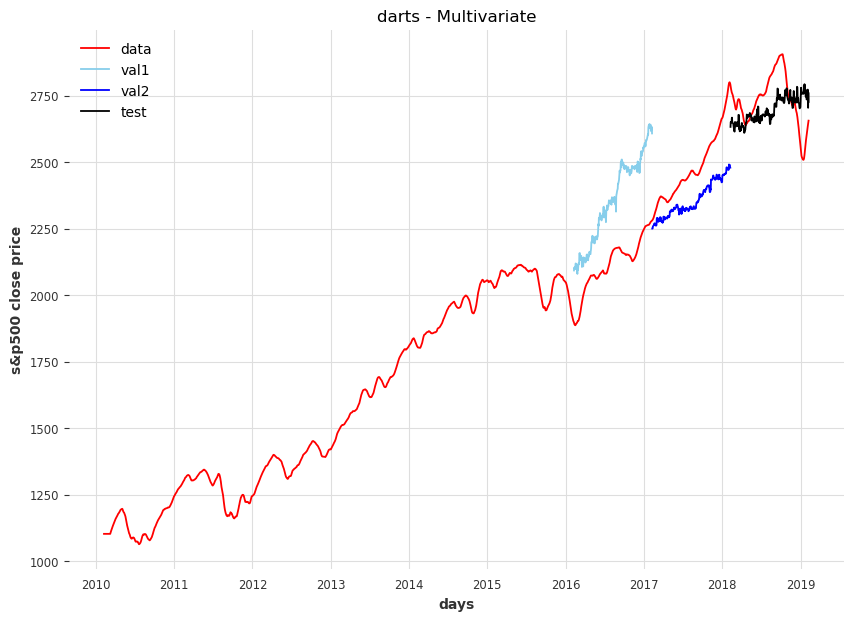

In [2]:
from darts.models import LinearRegressionModel

lags = [-365, -365, -365]  # Example lags
model1 = LinearRegressionModel(lags=lags)
model1.fit(train1)
forecast1 = model1.predict(len(val1), num_samples=1)

lags = [-365, -365, -365]  # Example lags
model2 = LinearRegressionModel(lags=lags)
model2.fit(train2)
forecast2 = model2.predict(len(val2), num_samples=1)

lags = [-365, -365, -365]  # Example lags
model3 = LinearRegressionModel(lags=lags)
model3.fit(train3)
forecast3 = model3.predict(len(val3), num_samples=1)

forecast_avg1 = forecast1.pd_dataframe(copy=True, suppress_warnings=False)
prediction1 = forecast_avg1['sp5avg']
prediction1 = pd.Series(prediction1,name='prediction1')
forecast_avg2 = forecast2.pd_dataframe(copy=True, suppress_warnings=False)
prediction2 = forecast_avg2['sp5avg']
prediction2 = pd.Series(prediction2,name='prediction2')
forecast_avg3 = forecast3.pd_dataframe(copy=True, suppress_warnings=False)
prediction3 = forecast_avg3['sp5avg']
prediction3 = pd.Series(prediction3,name='prediction3')

df = df.set_index('date')
df = pd.concat([df, prediction1,prediction2,prediction3], axis=1)

plt.figure(figsize=(10, 7))
plt.plot(df.index, df['sp5avg'], color="red", label="data")
plt.plot(df[(df.index>'2016-02-07')&(df.index<='2017-02-07')].index, df[(df.index>'2016-02-07')&(df.index<='2017-02-07')]['prediction1'] , color="skyblue", label="val1")
plt.plot(df[(df.index>'2017-02-07')&(df.index<='2018-02-07')].index, df[(df.index>'2017-02-07')&(df.index<='2018-02-07')]['prediction2'] , color="blue", label="val2")
plt.plot(df[(df.index>'2018-02-07')&(df.index<='2019-02-07')].index, df[(df.index>'2018-02-07')&(df.index<='2019-02-07')]['prediction3'] , color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('darts - Multivariate')
plt.legend()
plt.show()

In [9]:
# Calculate the Mean Absolute Error on the validation set
mae1 = mean_absolute_error(df[(df.index>'2016-02-08')&(df.index<='2017-02-07')]['sp5avg'], df[(df.index>'2016-02-08')&(df.index<='2017-02-07')]['prediction1'])
mae2 = mean_absolute_error(df[(df.index>'2017-02-08')&(df.index<='2018-02-07')]['sp5avg'], df[(df.index>'2017-02-08')&(df.index<='2018-02-07')]['prediction2'])
mae3 = mean_absolute_error(df[(df.index>'2018-02-08')&(df.index<='2019-02-07')]['sp5avg'], df[(df.index>'2018-02-08')&(df.index<='2019-02-07')]['prediction3'])
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 240.1742
MAE: 123.4301
MAE: 93.5372


In [11]:
# Read a pandas DataFrame
df=pd.read_csv('database(alldays)2.csv')
df=df[['date','sp5avg','timing','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close']]
df['date']=pd.to_datetime(df['date'])
df = df[(df['date']>'2011-02-07')&(df['date']<='2019-02-07')]

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'date', ['sp5avg','timing','inf_close','spr_close','int_close','dj_close','dj_volume','vix_close'])

# Set aside the last 365 days as a validation series
train1, val1 = series[:-1095], series[-1095:-730]

# Set aside the last 365 days as a validation series
train2, val2 = series[:-730], series[-730:-365]
                                                
# Set aside the last 365 days as a validation series
train3, val3 = series[:-365], series[-365:]

from darts.models import LinearRegressionModel

lags = [-365, -365, -365]  # Example lags
model1 = LinearRegressionModel(lags=lags)
model1.fit(train1)
forecast1 = model1.predict(len(val1), num_samples=1)

lags = [-365, -365, -365]  # Example lags
model2 = LinearRegressionModel(lags=lags)
model2.fit(train2)
forecast2 = model2.predict(len(val2), num_samples=1)

lags = [-365, -365, -365]  # Example lags
model3 = LinearRegressionModel(lags=lags)
model3.fit(train3)
forecast3 = model3.predict(len(val3), num_samples=1)

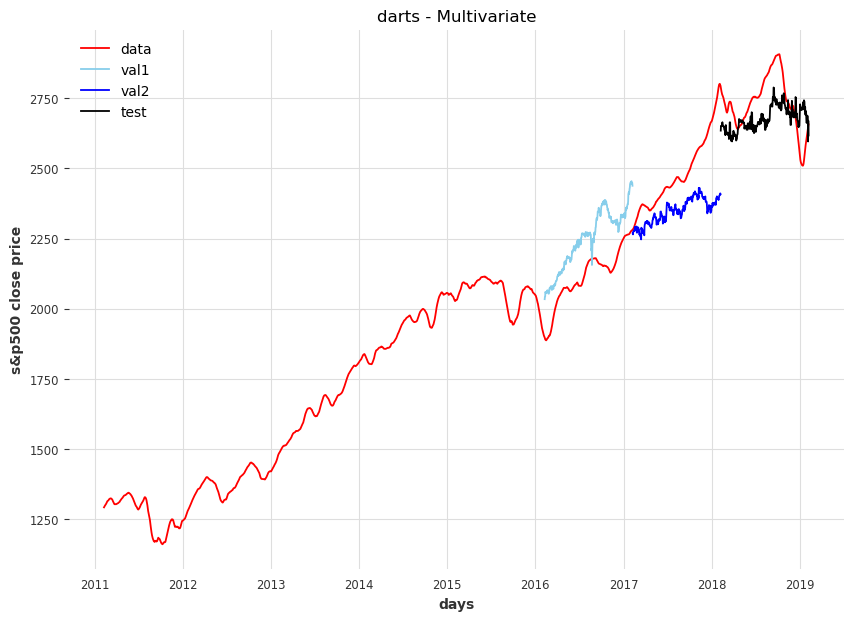

In [12]:
forecast_avg1 = forecast1.pd_dataframe(copy=True, suppress_warnings=False)
prediction1 = forecast_avg1['sp5avg']
prediction1 = pd.Series(prediction1,name='prediction1')
forecast_avg2 = forecast2.pd_dataframe(copy=True, suppress_warnings=False)
prediction2 = forecast_avg2['sp5avg']
prediction2 = pd.Series(prediction2,name='prediction2')
forecast_avg3 = forecast3.pd_dataframe(copy=True, suppress_warnings=False)
prediction3 = forecast_avg3['sp5avg']
prediction3 = pd.Series(prediction3,name='prediction3')

df = df.set_index('date')
df = pd.concat([df, prediction1,prediction2,prediction3], axis=1)

plt.figure(figsize=(10, 7))
plt.plot(df.index, df['sp5avg'], color="red", label="data")
plt.plot(df[(df.index>'2016-02-07')&(df.index<='2017-02-07')].index, df[(df.index>'2016-02-07')&(df.index<='2017-02-07')]['prediction1'] , color="skyblue", label="val1")
plt.plot(df[(df.index>'2017-02-07')&(df.index<='2018-02-07')].index, df[(df.index>'2017-02-07')&(df.index<='2018-02-07')]['prediction2'] , color="blue", label="val2")
plt.plot(df[(df.index>'2018-02-07')&(df.index<='2019-02-07')].index, df[(df.index>'2018-02-07')&(df.index<='2019-02-07')]['prediction3'] , color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('darts - Multivariate')
plt.legend()
plt.show()

In [13]:
# Calculate the Mean Absolute Error on the validation set
mae1 = mean_absolute_error(df[(df.index>'2016-02-08')&(df.index<='2017-02-07')]['sp5avg'], df[(df.index>'2016-02-08')&(df.index<='2017-02-07')]['prediction1'])
mae2 = mean_absolute_error(df[(df.index>'2017-02-08')&(df.index<='2018-02-07')]['sp5avg'], df[(df.index>'2017-02-08')&(df.index<='2018-02-07')]['prediction2'])
mae3 = mean_absolute_error(df[(df.index>'2018-02-08')&(df.index<='2019-02-07')]['sp5avg'], df[(df.index>'2018-02-08')&(df.index<='2019-02-07')]['prediction3'])
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 132.4486
MAE: 133.8737
MAE: 92.6947


# 10. Darts: Univariate

In [14]:
#Base
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from darts import TimeSeries

# Read a pandas DataFrame
df=pd.read_csv('database(alldays)2.csv')
df=df[['date','sp5avg']]
df['date']=pd.to_datetime(df['date'])
df = df[(df['date']>'2011-02-07')&(df['date']<='2019-02-07')]
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'date', 'sp5avg')

# Set aside the last 730 days as a validation series
train1, val1 = series[:-1095], series[-1095:-730]

# Set aside the last 365 days as a validation series
train2, val2 = series[:-730], series[-730:-365]
                                                
# Set aside the last 365 days as a validation series
train3, val3 = series[:-365], series[-365:]

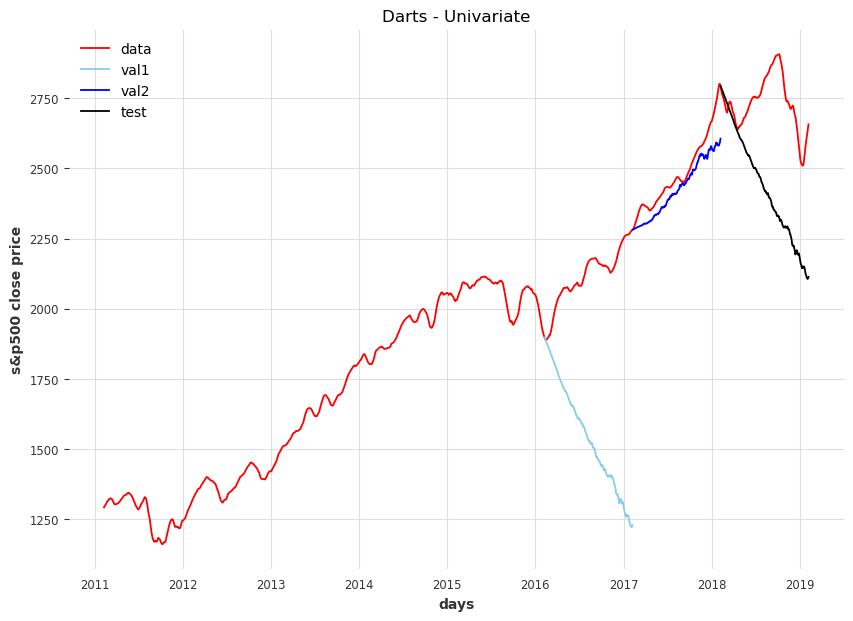

In [15]:
from darts.models import ExponentialSmoothing


p = 1  # AR order (number of lags for the target series)
q = 1  # MA order (number of lags for the moving average)
model1 = ExponentialSmoothing()
model1.fit(train1)
forecast1 = model1.predict(len(val1), num_samples=1000)

p = 1  # AR order (number of lags for the target series)
q = 1  # MA order (number of lags for the moving average)
model2 = ExponentialSmoothing()
model2.fit(train2)
forecast2 = model2.predict(len(val2), num_samples=1000)

p = 1  # AR order (number of lags for the target series)
q = 1  # MA order (number of lags for the moving average)
model3 = ExponentialSmoothing()
model3.fit(train3)
forecast3 = model3.predict(len(val3), num_samples=1000)

forecast_avg1 = TimeSeries.quantile_timeseries(forecast1, quantile=0.5)
prediction1 = forecast_avg1.pd_dataframe(copy=True, suppress_warnings=False)
prediction1.rename(columns={'sp5avg_0.5':'prediction1'},inplace=True)
forecast_avg2 = TimeSeries.quantile_timeseries(forecast2, quantile=0.5)
prediction2 = forecast_avg2.pd_dataframe(copy=True, suppress_warnings=False)
prediction2.rename(columns={'sp5avg_0.5':'prediction2'},inplace=True)
forecast_avg3 = TimeSeries.quantile_timeseries(forecast3, quantile=0.5)
prediction3 = forecast_avg3.pd_dataframe(copy=True, suppress_warnings=False)
prediction3.rename(columns={'sp5avg_0.5':'prediction3'},inplace=True)


df = df.set_index('date')
df = pd.concat([df, prediction1,prediction2,prediction3], axis=1)

plt.figure(figsize=(10, 7))
plt.plot(df[(df.index>'2010-02-07')&(df.index<='2019-02-07')].index, df[(df.index>'2010-02-07')&(df.index<='2019-02-07')]['sp5avg'], color="red", label="data")
plt.plot(df[(df.index>'2016-02-07')&(df.index<='2017-02-07')].index, df[(df.index>'2016-02-07')&(df.index<='2017-02-07')]['prediction1'] , color="skyblue", label="val1")
plt.plot(df[(df.index>'2017-02-07')&(df.index<='2018-02-07')].index, df[(df.index>'2017-02-07')&(df.index<='2018-02-07')]['prediction2'] , color="blue", label="val2")
plt.plot(df[(df.index>'2018-02-07')&(df.index<='2019-02-07')].index, df[(df.index>'2018-02-07')&(df.index<='2019-02-07')]['prediction3'] , color="black", label="test")
plt.ylabel("s&p500 close price")
plt.xlabel("days")
plt.title('Darts - Univariate')
plt.legend()
plt.show()

In [16]:
# Calculate the Mean Absolute Error on the validation set
mae1 = mean_absolute_error(df[(df.index>'2016-02-08')&(df.index<='2017-02-07')]['sp5avg'], df[(df.index>'2016-02-08')&(df.index<='2017-02-07')]['prediction1'])
mae2 = mean_absolute_error(df[(df.index>'2017-02-08')&(df.index<='2018-02-07')]['sp5avg'], df[(df.index>'2017-02-08')&(df.index<='2018-02-07')]['prediction2'])
mae3 = mean_absolute_error(df[(df.index>'2018-02-08')&(df.index<='2019-02-07')]['sp5avg'], df[(df.index>'2018-02-08')&(df.index<='2019-02-07')]['prediction3'])
print(f"MAE: {mae1:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"MAE: {mae3:.4f}")

MAE: 570.5977
MAE: 55.5022
MAE: 301.9976
